In [3]:
import time
import numpy as np
import pandas as pd
import argparse
import torch
from accelerate import Accelerator, DeepSpeedPlugin
from accelerate import DistributedDataParallelKwargs
from torch import nn, optim
from torch.optim import lr_scheduler
from tqdm import tqdm

from models import Autoformer, DLinear, TimeLLM, BatteryGPT
from log import set_logger


from data_provider.data_factory import data_provider
from utils.tools import del_files, EarlyStopping, adjust_learning_rate, vali, load_content
from utils.losses import smape_loss, mase_loss, mape_loss


## 验证模型

In [4]:
filetime = time.strftime('%Y%m%d%H%M', time.localtime())
parser = argparse.ArgumentParser(description='Time-LLM')

# basic config
parser.add_argument('--task_name', type=str, required=False, default='long_term_forecast',
                    help='task name, options:[long_term_forecast, short_term_forecast, imputation, classification, anomaly_detection]')
parser.add_argument('--is_training', type=int, required=False, default=1, help='status')
parser.add_argument('--model_id', type=str, required=False, default='Battery', help='model id')
parser.add_argument('--model_comment', type=str, required=False, default='none', help='prefix when saving test results')
parser.add_argument('--model', type=str, required=False, default='BatteryGPT',
                    help='model name, options: [Autoformer, DLinear]')
parser.add_argument('--seed', type=int, default=42, help='random seed')

# data loader
parser.add_argument('--data', type=str, required=False, default='masked_battery', help='dataset type')
parser.add_argument('--root_path', type=str, default='./dataset/my', help='root path of the data file')
parser.add_argument('--data_path', type=str, default='trimmed_LX3_ss0_se100_cr05_C_V_T_vs_CE.csv', help='data file')
parser.add_argument('--drop_bid', type=int, default=0)
parser.add_argument('--cutting_rate', type=float, default=1.2)
parser.add_argument('--features', type=str, default='M',
                    help='forecasting task, options:[M, S, MS]; '
                            'M:multivariate predict multivariate, S: univariate predict univariate, '
                            'MS:multivariate predict univariate')
parser.add_argument('--target', type=str, default='OT', help='target feature in S or MS task')
parser.add_argument('--loader', type=str, default='modal', help='dataset type')
parser.add_argument('--freq', type=str, default='h',
                    help='freq for time features encoding, '
                            'options:[s:secondly, t:minutely, h:hourly, d:daily, b:business days, w:weekly, m:monthly], '
                            'you can also use more detailed freq like 15min or 3h')
parser.add_argument('--checkpoints', type=str, default='./cache/', help='location of model checkpoints')
parser.add_argument('--logger', type=str, default='./logs', help='log folder')
parser.add_argument('--on_server', type=bool, default=False)

# forecasting task
parser.add_argument('--seq_limit', type=int, default=48, help='raw sequence length')
parser.add_argument('--seq_len', type=int, default=18, help='input sequence length')
parser.add_argument('--label_len', type=int, default=9, help='start token length')
parser.add_argument('--pred_len', type=int, default=30, help='prediction sequence length')
parser.add_argument('--seasonal_patterns', type=str, default='Monthly', help='subset for M4')

# model define
parser.add_argument('--enc_in', type=int, default=11, help='encoder input size')
parser.add_argument('--dec_in', type=int, default=7, help='decoder input size')
parser.add_argument('--c_out', type=int, default=1, help='output size')
parser.add_argument('--d_model', type=int, default=16, help='dimension of model')
parser.add_argument('--n_heads', type=int, default=8, help='num of heads')
parser.add_argument('--e_layers', type=int, default=2, help='num of encoder layers')
parser.add_argument('--d_layers', type=int, default=1, help='num of decoder layers')
parser.add_argument('--d_ff', type=int, default=32, help='dimension of fcn')
parser.add_argument('--moving_avg', type=int, default=25, help='window size of moving average')
parser.add_argument('--factor', type=int, default=1, help='attn factor')
parser.add_argument('--dropout', type=float, default=0.1, help='dropout')
parser.add_argument('--embed', type=str, default='timeF',
                    help='time features encoding, options:[timeF, fixed, learned]')
parser.add_argument('--activation', type=str, default='gelu', help='activation')
parser.add_argument('--output_attention', action='store_true', help='whether to output attention in encoder')
parser.add_argument('--patch_len', type=int, default=8, help='patch length')
parser.add_argument('--stride', type=int, default=4, help='stride')
parser.add_argument('--prompt_domain', type=int, default=0, help='')

# optimization
parser.add_argument('--num_workers', type=int, default=1, help='data loader num workers')
parser.add_argument('--itr', type=int, default=1, help='experiments times')
parser.add_argument('--train_epochs', type=int, default=10, help='train epochs')
parser.add_argument('--align_epochs', type=int, default=10, help='alignment epochs')
parser.add_argument('--batch_size', type=int, default=8, help='batch size of train input data')
parser.add_argument('--eval_batch_size', type=int, default=8, help='batch size of model evaluation')
parser.add_argument('--patience', type=int, default=10, help='early stopping patience')
parser.add_argument('--learning_rate', type=float, default=0.001, help='optimizer learning rate')
parser.add_argument('--des', type=str, default='test', help='exp description')
parser.add_argument('--loss', type=str, default='MSE', help='loss function')
parser.add_argument('--lradj', type=str, default='type1', help='adjust learning rate')
parser.add_argument('--pct_start', type=float, default=0.2, help='pct_start')
parser.add_argument('--use_amp', action='store_true', help='use automatic mixed precision training', default=False)
parser.add_argument('--llm_layers', type=int, default=6)
parser.add_argument('--percent', type=int, default=100)

args = parser.parse_args(args=[])
accelerator = Accelerator(mixed_precision='bf16', device_placement=False)

# 还原训练参数
args.llm_layers = 32
args.d_model = 32
args.d_ff = 128
args.enc_in = 11
args.dec_in = 7
args.c_out = 1

args.batch_size = 1


In [5]:
# 读取数据
# train_data, train_loader = data_provider(args, 'train')
# vali_data, vali_loader = data_provider(args, 'val')
test_data, test_loader = data_provider(args, 'test')

data-2 load completed: (27471,) lunci


In [6]:
# 读取模型
sd_path = r'./cache\long_term_forecast_Battery_BatteryGPT_masked_battery_ftM_sl18_ll9_pl30_dm32_nh8_el2_dl1_df128_fc1_ebtimeF_Exp_0-BatteryGPT-Masked_battery\checkpoint'
model = BatteryGPT.Model(args).float()
model.load_state_dict(torch.load(sd_path))

test_loader, model = accelerator.prepare(
    test_loader, model)


In [7]:
# 模型参数量
cnts = 0
for param in model.parameters():
    cnts += param.numel()
cnts

318867546

In [8]:
# 验证模型

model.to(accelerator.device)
criterion = nn.MSELoss()
mae_metric = nn.L1Loss()

y = []
yhat = []
model.eval()
for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(test_loader):
    print('batch %d' %i)
    batch_x = batch_x.float().to(accelerator.device)
    batch_y = batch_y.float().to(accelerator.device)
    batch_x_mark = batch_x_mark.float().to(accelerator.device)
    batch_y_mark = batch_y_mark.float().to(accelerator.device)

    # decoder input
    dec_inp = torch.zeros_like(batch_y[:, -args.pred_len:, :]).float()
    dec_inp = torch.cat([batch_y[:, :args.label_len, :], dec_inp], dim=1).float()

    outputs = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
    f_dim = -1 if args.features == 'MS' else 0
    outputs = outputs[:, -args.pred_len:, f_dim:]
    batch_y = batch_y[:, -args.pred_len:, f_dim:]

    pred = outputs.detach().cpu().numpy()
    true = batch_y.detach().cpu().numpy()

    # loss = criterion(pred, true)
    # mae_loss = mae_metric(pred, true)

    y.append(true)
    yhat.append(pred)

    break


batch 0


In [14]:
y1 = np.array(y)
yhat1 = np.array(yhat)

y1.shape

(1, 1, 30, 11)

In [9]:
y1 = np.array(y)
yhat1 = np.array(yhat)

y1 = np.squeeze(y1)
yhat1 = np.squeeze(yhat1)

# 将前两个维度作为 MultiIndex
index = pd.MultiIndex.from_product([range(s) for s in y1.shape[:3]], names=['batch', 'seq', 'id'])
# 将数组转换为 DataFrame
df1 = pd.DataFrame(y1.reshape(-1), index=index, columns=['y'])
# 将前两个维度作为 MultiIndex
index = pd.MultiIndex.from_product([range(s) for s in yhat1.shape[:3]], names=['batch', 'seq', 'id'])
# 将数组转换为 DataFrame
df2 = pd.DataFrame(yhat1.reshape(-1), index=index, columns=['yhat'])

df = pd.concat([df1, df2], axis=1)
display(df)

# df.to_csv('./ana.csv')


ValueError: Length of names must match number of levels in MultiIndex.

In [10]:
df = pd.read_csv('./ana.csv')
df

,batch,seq,id,y,yhat
0,0,0,0,0.351341,-0.204259
1,0,0,1,0.063353,0.511029
2,0,0,2,0.143866,-0.379806
3,0,0,3,0.028774,-0.146616
4,0,0,4,0.086234,-0.068013
...,...,...,...,...,...
1867771,303,63,91,-1.513897,-1.438466
1867772,303,63,92,-1.544519,-1.371871
1867773,303,63,93,-1.529262,-1.419550
1867774,303,63,94,-1.605871,-1.345620


<Axes: xlabel='id'>

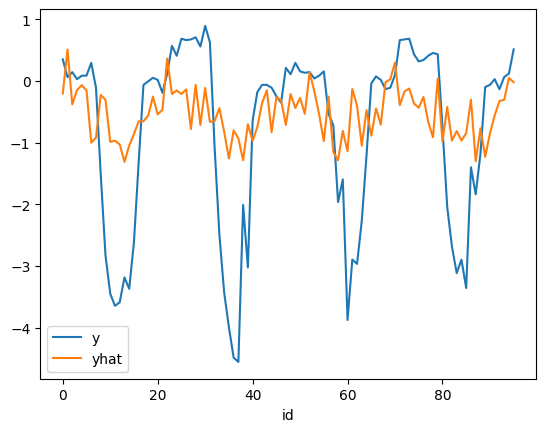

In [9]:
df1 = df.set_index(['batch', 'seq', 'id'])
df1.loc[(0,0), :].plot()

<Axes: xlabel='id'>

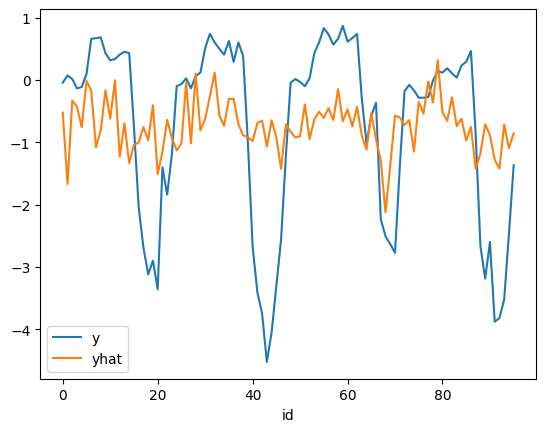

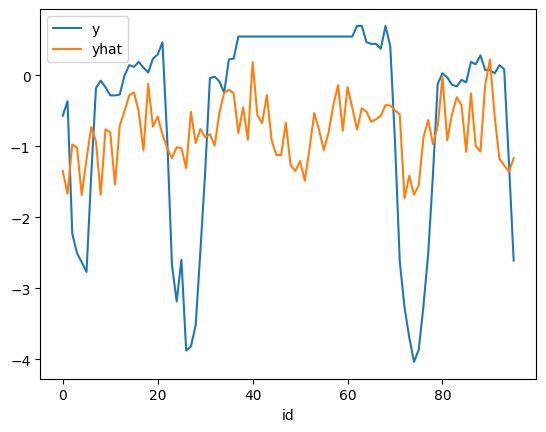

In [12]:
df1.loc[(1,1), :].plot()
df1.loc[(2,2), :].plot()